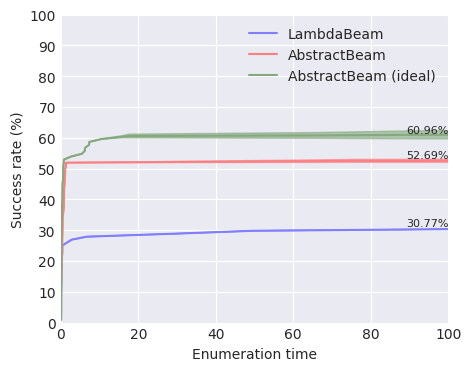

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Colors
colors = ["#807fff", "#fd7f82", "#84a97e"]

approaches = [
    "/work/ldierkes/repos/new/LambdaBeam/outputs/baseline_3/eval/",
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/eval/",
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/all_inventions/eval/"
]

labels = ['LambdaBeam', 'AbstractBeam', 'AbstractBeam (ideal)']
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(5, 4))

plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))

all_success_rates = []

for i, approach_file in enumerate(approaches):
    success_rates = []

    for j in range(1, 6):  # Loop over the 5 runs
        with open(approach_file + f'results_{j}.json') as f:
            results = json.load(f)["results"]

        elapsed_time = []
        success = []

        for sol in results:
            if sol["elapsed_time"]:
                elapsed_time.append(sol["elapsed_time"])
                success.append(sol["success"])

        sorted_data = sorted(zip(elapsed_time, success))
        
        sorted_time_taken, sorted_tasks_solved = zip(*sorted_data)
        cumulative_tasks = [sum(sorted_tasks_solved[:k+1]) for k in range(len(sorted_tasks_solved))]
        success_rate = [cumulative_task / len(results) * 100 for cumulative_task in cumulative_tasks]

        if len(success_rate) < len(sorted_time_taken):
            success_rate.append(success_rate[-1])

        success_rates.append(success_rate)

    # Calculate mean and standard deviation
    mean_success_rate = np.mean(success_rates, axis=0)
        
    # get index of sorted_time_taken where it is first time over 50
    sorted_time_taken_index_50 = np.where(np.array(sorted_time_taken) > 100)[0][0]
    final_success_rate = mean_success_rate[sorted_time_taken_index_50]

    std_success_rate = np.std(success_rates, axis=0)
    
    # Plot mean
    plt.plot(sorted_time_taken, mean_success_rate, linestyle='-', label=labels[i], color=colors[i])

    # Plot uncertainty area
    plt.fill_between(sorted_time_taken, mean_success_rate - std_success_rate, mean_success_rate + std_success_rate,
                     alpha=0.6, color=colors[i])
    
    plt.text(100, final_success_rate, f'{final_success_rate:.2f}%', ha='right', va='bottom', fontsize=8)

    all_success_rates.append(mean_success_rate)

# Plot overall mean
#overall_mean = np.mean(all_success_rates, axis=0)
#plt.plot(sorted_time_taken, overall_mean, linestyle='--', color='black', label='Overall Mean')

# plot size
plt.xlabel('Enumeration time')
plt.ylabel('Success rate (%)')
plt.legend()
plt.grid(True)
plt.style.use('seaborn-v0_8-darkgrid')
# max x 
plt.xlim(0, 100)

plt.show()


In [2]:
import os
from git import Repo

# Get the current working directory
current_directory = os.getcwd()

# Find the root directory of the Git repository
repo = Repo(current_directory)
git_root = repo.git.rev_parse("--show-toplevel")

InvalidGitRepositoryError: /work/ldierkes/repos/new/LambdaBeam/consolidation

In [6]:
import git
import pickle
repo = git.Repo('.', search_parent_directories=True)
repo_dir = repo.working_tree_dir

In [7]:
with open(repo_dir + "/crossbeam/data/dreamcoder_test_tasks.pkl", 'rb') as file:
        original_tasks = pickle.load(file)

LambdaBeam: Median weight: 7.00, Median time: 0.92, Median programs: 491.00
AbstractBeam: Median weight: 4.00, Median time: 0.54, Median programs: 235.00
AbstractBeam (ideal): Median weight: 4.00, Median time: 0.15, Median programs: 202.00


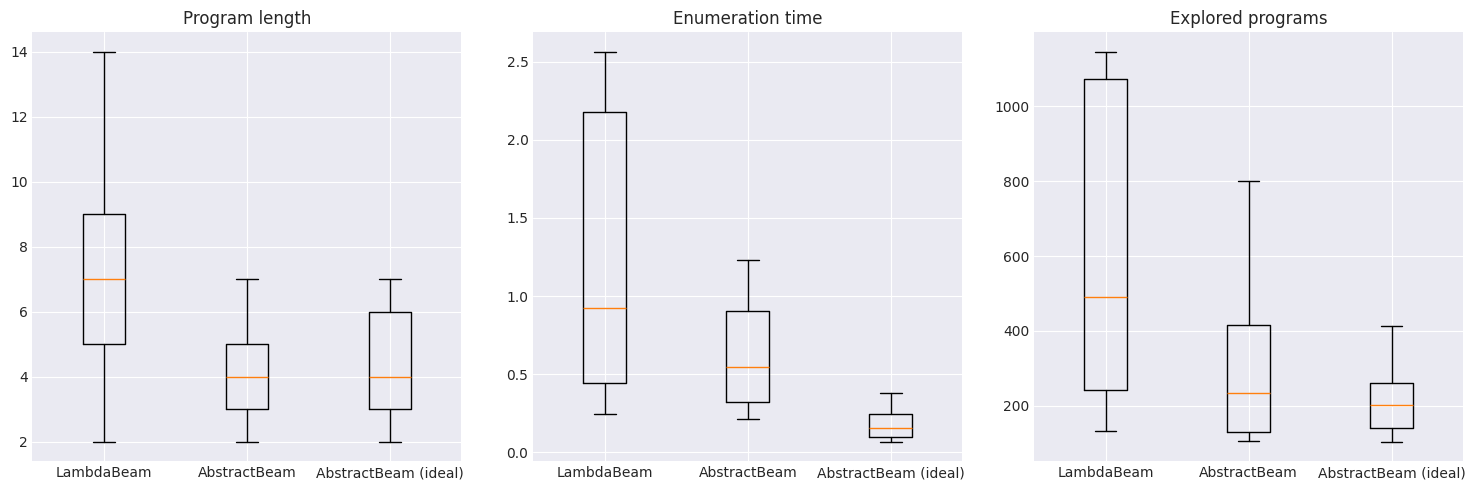

In [7]:
import json
import re
from crossbeam.data.deepcoder.solution_weight import solution_weight

approaches = [
    "/work/ldierkes/repos/new/LambdaBeam/outputs/baseline_3/eval/",
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/eval/",
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/all_inventions/eval/"
]

labels = ["LambdaBeam", "AbstractBeam", "AbstractBeam (ideal)"]
name_pattern = re.compile(r"name='(.*?)'")

solved_tasks_over_all_runs = {"AbstractBeam": set(), "LambdaBeam": set(), "AbstractBeam (ideal)": set()}

# Load results for each approach
for approach, label in zip(approaches, labels):
    for i in range(1, 6):  # Loop over the 5 runs
        with open(approach + f"results_{i}.json") as f:
            results = json.load(f)["results"]

        for result in results:
            name = name_pattern.search(result["task"]).group(1)
            if result["success"]:
                solved_tasks_over_all_runs[label].add(name)

all_solved_tasks = set()
ll_solved_tasks = set()
for result in results:
    # Check if all approaches solved the task
    name = name_pattern.search(result["task"]).group(1)
    if name in solved_tasks_over_all_runs["AbstractBeam"] and name in solved_tasks_over_all_runs["LambdaBeam"] and name in solved_tasks_over_all_runs["AbstractBeam (ideal)"]:
        all_solved_tasks.add(name)
    if name in solved_tasks_over_all_runs["AbstractBeam"] and name in solved_tasks_over_all_runs["AbstractBeam (ideal)"]:
        ll_solved_tasks.add(name)
        

results_stats = {
    "LambdaBeam": {name: {"weights": [], "times": [], "programs": []} for name in all_solved_tasks},
    "AbstractBeam": {name: {"weights": [], "times": [], "programs": []} for name in all_solved_tasks},
    "AbstractBeam (ideal)": {name: {"weights": [], "times": [], "programs": []} for name in all_solved_tasks},
}

for approach, label in zip(approaches, labels):
    for i in range(1, 6):  # Loop over the 5 runs
        with open(approach + f"results_{i}.json") as f:
            results = json.load(f)["results"]
    
        for result in results:
            name = name_pattern.search(result["task"]).group(1)
            if name in all_solved_tasks and result["success"]:
                # weight
                program = result["solution"]
                program = program.replace("[]", "empty")
                results_stats[label][name]["weights"].append(solution_weight(program))

                # time
                results_stats[label][name]["times"].append(result["elapsed_time"])

                # candidate programs 
                results_stats[label][name]["programs"].append(result["stats"]["total_num_values_explored"])

    for name in all_solved_tasks:
        results_stats[label][name]["weights"] = np.mean(results_stats[label][name]["weights"])
        results_stats[label][name]["times"] = np.mean(results_stats[label][name]["times"])
        results_stats[label][name]["programs"] = np.mean(results_stats[label][name]["programs"])

for label in labels:
    results_stats[label]["average_weights"] = [results_stats[label][name]["weights"] for name in all_solved_tasks]
    results_stats[label]["average_times"] = [results_stats[label][name]["times"] for name in all_solved_tasks]
    results_stats[label]["average_programs"] = [results_stats[label][name]["programs"] for name in all_solved_tasks]


weights_data = [results_stats[label]["average_weights"] for label in results_stats]
times_data = [results_stats[label]["average_times"] for label in results_stats]
programs_data = [results_stats[label]["average_programs"] for label in results_stats]


for label in labels:
    # Median weight
    median_weight = np.median(results_stats[label]["average_weights"])

    # Median time
    median_time = np.median(results_stats[label]["average_times"])

    # Median programs
    median_programs = np.median(results_stats[label]["average_programs"])

    print(f"{label}: Median weight: {median_weight:.2f}, Median time: {median_time:.2f}, Median programs: {median_programs:.2f}")

# Creating box plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(weights_data, showfliers=False)
plt.xticks(range(1, len(results_stats) + 1), results_stats.keys())
#plt.text(0.5, -0.15, "(a)", transform=plt.gca().transAxes, ha='center', fontsize=17)
plt.title('Program length')

plt.subplot(1, 3, 2)
plt.boxplot(times_data, showfliers=False)
plt.xticks(range(1, len(results_stats) + 1), results_stats.keys())
#plt.text(0.5, -0.15, "(b)", transform=plt.gca().transAxes, ha='center', fontsize=17)
plt.title('Enumeration time')

plt.subplot(1, 3, 3)
plt.boxplot(programs_data, showfliers=False)
plt.xticks(range(1, len(results_stats) + 1), results_stats.keys())
#plt.text(0.5, -0.15, "(c)", transform=plt.gca().transAxes, ha='center', fontsize=17)
plt.title('Explored programs')

plt.tight_layout()
plt.show()


/tmp/ipykernel_166952/31917805.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(results_stats.keys())


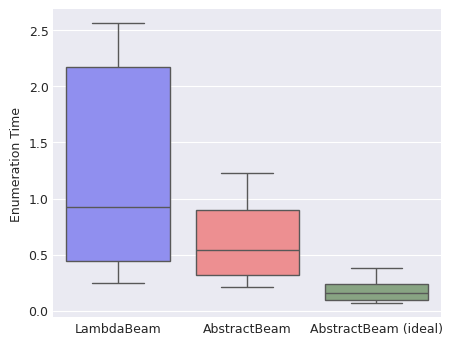

In [8]:
import seaborn as sns
plt.figure(figsize=(5, 4))
plt.rcParams['xtick.labelsize'] = 9
# ylabel size
plt.rcParams['ytick.labelsize'] = 9

colors = ["#807fff", "#fd7f82", "#84a97e"]
sns.set_palette(sns.color_palette(colors))

boxplot = sns.boxplot(data=times_data, showfliers=False,
                      #order=["LambdaBeam", "AbstractBeam", "AbstractBeam (ideal)"], 
                      fliersize=0)


#boxplot.set_xlabel(["LambdaBeam", "AbstractBeam", "AbstractBeam (ideal)"])
boxplot.set_ylabel("Enumeration Time", fontsize=9)
boxplot.set_xticklabels(results_stats.keys())
plt.show()

/tmp/ipykernel_166952/3932040126.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(results_stats.keys())


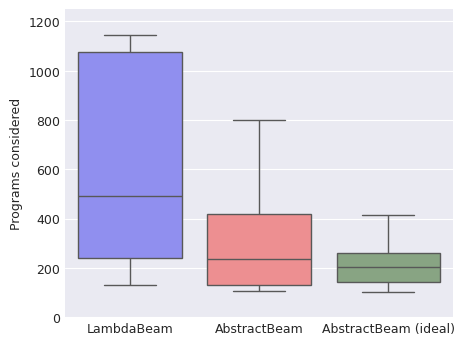

In [9]:
plt.figure(figsize=(5, 4))
plt.rcParams['xtick.labelsize'] = 9
# ylabel size
plt.rcParams['ytick.labelsize'] = 9

colors = ["#807fff", "#fd7f82", "#84a97e"]
sns.set_palette(sns.color_palette(colors))

boxplot = sns.boxplot(data=programs_data, 
                      fliersize=0)


boxplot.set_ylabel("Programs considered", fontsize=9)
boxplot.set_xticklabels(results_stats.keys())

plt.ylim(0, 1250)

plt.show()

/tmp/ipykernel_166952/2931552953.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(results_stats.keys())


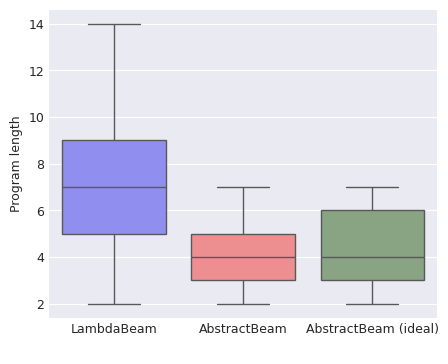

In [10]:
plt.figure(figsize=(5, 4))
plt.rcParams['xtick.labelsize'] = 9
# ylabel size
plt.rcParams['ytick.labelsize'] = 9

colors = ["#807fff", "#fd7f82", "#84a97e"]
sns.set_palette(sns.color_palette(colors))

boxplot = sns.boxplot(data=weights_data, 
                      #order=["LambdaBeam", "AbstractBeam", "AbstractBeam (ideal)"], 
                      fliersize=0)


#boxplot.set_xlabel(["LambdaBeam", "AbstractBeam", "AbstractBeam (ideal)"])
boxplot.set_ylabel("Program length", fontsize=9)
boxplot.set_xticklabels(results_stats.keys())

boxplot.set_xlabel(" ", fontsize=9)

plt.show()

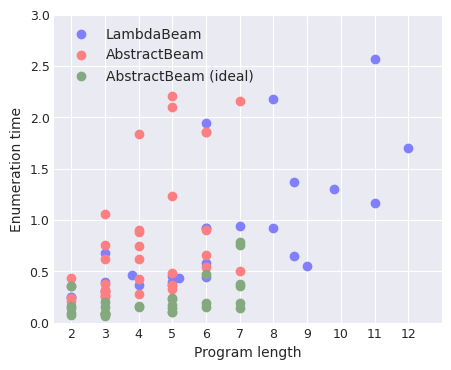

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Apply seaborn style
plt.style.use('seaborn-v0_8-darkgrid')

labels = ["LambdaBeam", "AbstractBeam", "AbstractBeam (ideal)"]
colors = ["#807fff", "#fd7f82", "#84a97e"]
palette = sns.color_palette(colors)

plt.figure(figsize=(5, 4))

for i, sublist in enumerate(weights_data):
    plt.scatter(sublist, times_data[i], label=labels[i], c=[palette[i]])

plt.xlabel('Program length')
plt.ylabel('Enumeration time')
plt.xticks(range(1, 13))
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
plt.ylim(0, 3)
plt.xlim(1.5, 13)

# Customize legend with edges and white background color
legend = plt.legend(loc='upper left')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

# Set legend's zorder to bring it to the foreground
legend.set_zorder(10)

plt.show()


Performance of LambdaBeam after 10000 programs: 31.73%
Performance of AbstractBeam after 10000 programs: 53.27%
Performance of AbstractBeam (ideal) after 10000 programs: 60.96%


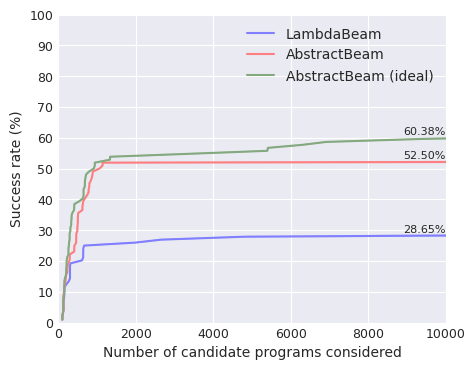

In [12]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Colors
colors = ["#807fff", "#fd7f82", "#84a97e"]

def load_and_process_results(file_paths):
    all_cumulative_tasks = []
    for file_path in file_paths:
        with open(file_path) as f:
            results = json.load(f)["results"]
        
        num_programs, success = zip(*[(sol["stats"]["total_num_values_explored"], sol["success"]) for sol in results if sol["stats"]["total_num_values_explored"]])
        sorted_data = sorted(zip(num_programs, success))
        sorted_time_taken, sorted_tasks_solved = zip(*sorted_data)
        cumulative_tasks = [sum(sorted_tasks_solved[:i+1]) / len(results) * 100 for i in range(len(sorted_tasks_solved))]
        all_cumulative_tasks.append(cumulative_tasks)
    
    return sorted_time_taken, all_cumulative_tasks

def plot_tasks_solved(result_paths, labels):
    plt.figure(figsize=(5, 4))  # Adjust figure size as needed
    
    all_success_rates = []
    
    for i, (result_path, label) in enumerate(zip(result_paths, labels)):
        all_sorted_time_taken, all_cumulative_tasks = load_and_process_results([result_path + f"results_{i}.json" for i in range(1, 6)])
        
        
        # Calculate mean and standard deviation
        mean_success_rate = np.mean(all_cumulative_tasks, axis=0)
        std_success_rate = np.std(all_cumulative_tasks, axis=0)
        
        # get index of sorted_time_taken where it is first time over 50
        index = np.where(np.array(all_sorted_time_taken) > 10000)[0][0]
        final_success_rate = mean_success_rate[index]

        print(f"Performance of {label} after 10000 programs: {mean_success_rate[-1]:.2f}%")
        
        # Plot mean
        plt.plot(all_sorted_time_taken, mean_success_rate, linestyle='-', label=label, color=colors[i])
        
        # Plot uncertainty area
        plt.fill_between(all_sorted_time_taken, mean_success_rate - std_success_rate, mean_success_rate + std_success_rate, alpha=0.2, color=colors[i])
        
        # Add text with final success rate
        plt.text(10000, final_success_rate, f'{final_success_rate:.2f}%', ha='right', va='bottom', fontsize=8)

        all_success_rates.append(mean_success_rate)
    
    plt.ylim(0, 100)
    plt.xlim(-1, 10000)
    plt.yticks(range(0, 101, 10))
    plt.xlabel('Number of candidate programs considered')
    plt.ylabel('Success rate (%)')
    plt.legend()
    plt.grid(True)
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.show()

# Example usage with multiple result paths, labels, and plot labels:
result_paths = [
    "/work/ldierkes/repos/new/LambdaBeam/outputs/baseline_3/eval/",
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/eval/",
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/all_inventions/eval/"
]

result_labels = ["LambdaBeam", "AbstractBeam", "AbstractBeam (ideal)"]

plot_tasks_solved(result_paths, result_labels)


LambdaBeam: {1: 73.33333333333333, 2: 18.857142857142854, 3: 0.0}
AbstractBeam: {1: 80.55555555555556, 2: 49.71428571428571, 3: 27.272727272727273}
AbstractBeam (ideal): {1: 83.33333333333334, 2: 58.857142857142854, 3: 38.78787878787879}


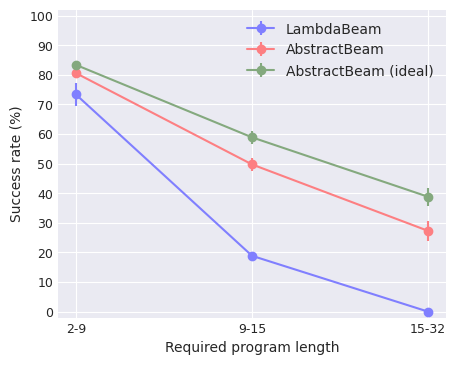

In [13]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt

# Colors
colors = ["#807fff", "#fd7f82", "#84a97e"]

name_pattern = re.compile(r"name='(.*?)'")
# Load data:
import pickle
with open("/work/ldierkes/repos/new/LambdaBeam/consolidation/data/task_to_length.pickle", "rb") as f:
    data = pickle.load(f)

tasks_dict = dict([(k, v[1]) for k, v in data.items()])
# test names
# open pickle file
with open("/work/ldierkes/repos/new/LambdaBeam/crossbeam/data/dreamcoder_test_tasks.pkl", "rb") as f:
    test_tasks = pickle.load(f)
names = [task.name for task in test_tasks]
tasks_dict = dict([(k ,v) for k, v in tasks_dict.items() if k in names])

task_values = list(tasks_dict.values())

# Determine the number of bins needed based on the minimum examples per bin
num_bins = 3

# Use numpy's percentile function to determine bin edges
bin_edges = np.percentile(task_values, np.linspace(0, 100, num_bins + 1))

# Assign tasks to bins based on values
bin_assignments = np.digitize(task_values, bin_edges, right=True)

# Create bins as dictionaries
bins = {bin_num: [] for bin_num in range(1, num_bins + 1)}

# Populate bins with tasks
for task, bin_num in zip(tasks_dict.keys(), bin_assignments):
    if bin_num == 0:
        bins[1].append(task)
        continue
    bins[bin_num].append(task)

approaches = [
    "/work/ldierkes/repos/new/LambdaBeam/outputs/baseline_3/eval/",
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/eval/",
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/all_inventions/eval/"
]

labels = ["LambdaBeam", "AbstractBeam", "AbstractBeam (ideal)"]

plt.figure(figsize=(5, 4))  # Adjust figure size as needed

for i, (approach, label) in enumerate(zip(approaches, labels)):
    all_solutions_per_bin = {bin_num: [] for bin_num in range(1, num_bins + 1)}
    for j in range(1, 6):  # Loop over the 5 runs
        with open(approach + f"results_{j}.json") as f:
            results = json.load(f)["results"]

        solutions_per_bin = {bin_num: 0 for bin_num in range(1, num_bins + 1)}

        for result in results:
            if result["success"]:
                name = name_pattern.search(result["task"]).group(1)
                for bin_num, bin_tasks in bins.items():
                    if name in bin_tasks:
                        solutions_per_bin[bin_num] += 1
                        break
        for bin_num in range(1, num_bins + 1):
            all_solutions_per_bin[bin_num].append(solutions_per_bin[bin_num] / len(bins[bin_num]) * 100)
    
    # Calculate mean and standard deviation
    mean_solutions_per_bin = {bin_num: np.mean(all_solutions_per_bin[bin_num]) for bin_num in range(1, num_bins + 1)}
    std_solutions_per_bin = {bin_num: np.std(all_solutions_per_bin[bin_num]) for bin_num in range(1, num_bins + 1)}
    
    print(f"{label}: {mean_solutions_per_bin}")

    # Plot mean
    bin_edges_x = [str(int(bin_edges[i]))+ "-" + str(int(bin_edges[i + 1])) for i in range(len(bin_edges) - 1)]
    plt.errorbar(bin_edges_x, list(mean_solutions_per_bin.values()), yerr=list(std_solutions_per_bin.values()), label=label, marker='o', color=colors[i])

plt.ylim(-2, 102)
plt.yticks(range(0, 101, 10))
plt.grid(True)
plt.xlabel('Required program length')
plt.ylabel('Success rate (%)')
plt.legend()
plt.style.use('seaborn-v0_8-darkgrid')

plt.show()


AbstractBeam: {1: 58.620689655172406, 2: 94.24148606811146, 3: 100.0}
AbstractBeam (ideal): {1: 53.333333333333336, 2: 95.13852813852813, 3: 100.0}


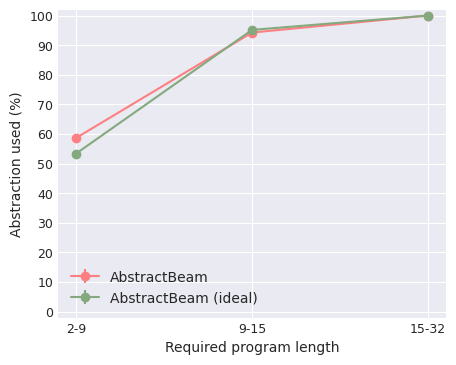

In [14]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt

# Colors
colors = ["#807fff", "#fd7f82", "#84a97e"]

name_pattern = re.compile(r"name='(.*?)'")
# Load data:
import pickle
with open("/work/ldierkes/repos/new/LambdaBeam/consolidation/data/task_to_length.pickle", "rb") as f:
    data = pickle.load(f)

tasks_dict = dict([(k, v[1]) for k, v in data.items()])
# test names
# open pickle file
with open("/work/ldierkes/repos/new/LambdaBeam/crossbeam/data/dreamcoder_test_tasks.pkl", "rb") as f:
    test_tasks = pickle.load(f)
names = [task.name for task in test_tasks]
tasks_dict = dict([(k ,v) for k, v in tasks_dict.items() if k in names])

task_values = list(tasks_dict.values())

# Determine the number of bins needed based on the minimum examples per bin
num_bins = 3

# Use numpy's percentile function to determine bin edges
bin_edges = np.percentile(task_values, np.linspace(0, 100, num_bins + 1))

# Assign tasks to bins based on values
bin_assignments = np.digitize(task_values, bin_edges, right=True)

# Create bins as dictionaries
bins = {bin_num: [] for bin_num in range(1, num_bins + 1)}

# Populate bins with tasks
for task, bin_num in zip(tasks_dict.keys(), bin_assignments):
    if bin_num == 0:
        bins[1].append(task)
        continue
    bins[bin_num].append(task)

approaches = [
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/eval/",
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/all_inventions/eval/"
]

labels = ["AbstractBeam", "AbstractBeam (ideal)"]

plt.figure(figsize=(5, 4))  # Adjust figure size as needed

for i, (approach, label) in enumerate(zip(approaches, labels)):
    all_abs_percentage_per_bin = {bin_num: [] for bin_num in range(1, num_bins + 1)}
    for j in range(1, 6):  # Loop over the 5 runs
        with open(approach + f"results_{j}.json") as f:
            results = json.load(f)["results"]

        solutions_per_bin = {bin_num: 0 for bin_num in range(1, num_bins + 1)}
        abstractions_per_bin = {bin_num: 0 for bin_num in range(1, num_bins + 1)}

        for result in results:
            if result["success"]:
                name = name_pattern.search(result["task"]).group(1)
                for bin_num, bin_tasks in bins.items():
                    if name in bin_tasks:
                        if "fn" in result["solution"]:
                            abstractions_per_bin[bin_num] += 1
                            solutions_per_bin[bin_num] += 1
                        else:
                            solutions_per_bin[bin_num] += 1

        abs_percentage_per_bin = {bin_num: abstractions / solutions_per_bin[bin_num] * 100 for bin_num, abstractions in
                                   abstractions_per_bin.items()}
        
        for bin_num in range(1, num_bins + 1):
            all_abs_percentage_per_bin[bin_num].append(abs_percentage_per_bin[bin_num])

    # Calculate mean and standard deviation
    mean_abs_percentage_per_bin = {bin_num: np.mean(all_abs_percentage_per_bin[bin_num]) for bin_num in range(1, num_bins + 1)}
    std_abs_percentage_per_bin = {bin_num: np.std(all_abs_percentage_per_bin[bin_num]) for bin_num in range(1, num_bins + 1)}

    print(f"{label}: {mean_abs_percentage_per_bin}")
    # Plot mean
    plt.errorbar(bin_edges_x, list(mean_abs_percentage_per_bin.values()), yerr=list(std_abs_percentage_per_bin.values()), label=label, marker='o', color=colors[i+1])


plt.ylim(-2, 102)
plt.yticks(range(0, 101, 10))
plt.grid(True)
plt.xlabel('Required program length')
plt.ylabel('Abstraction used (%)')
plt.legend()
plt.style.use('seaborn-v0_8-darkgrid')

plt.show()


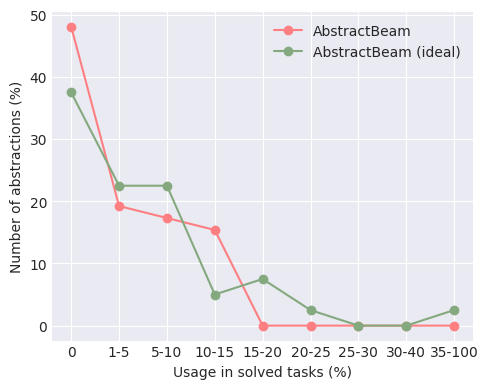

In [3]:
import torch
import json
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter

# Define paths and approaches
approaches = [
    {
        "ckpt_path": "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/model-best-valid.ckpt",
        "eval_path": "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/eval/",
        "label": "AbstractBeam"
    },
    {
        "ckpt_path": "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/all_inventions/model-best-valid.ckpt",
        "eval_path": "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/all_inventions/eval/",
        "label": "AbstractBeam (ideal)"
    }
]

# Define custom bins
custom_bins = [0, 1, 5, 10, 15, 20, 25, 30, 40, 100]
# darkgrid
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(5, 4))
colors = ["#fd7f82", "#84a97e"]

# For bar plot
success_rate_per_approach = []
succes_rate_with_inv_per_approach = []


# Loop through approaches
for c, approach in enumerate(approaches):
    # Initialize invention counter
    invention_counter = {}

    # Open ckpt file
    with open(approach["ckpt_path"], "rb") as f:
        ckpt = torch.load(f)

    invention_names = [inv.name for inv in ckpt["inventions"]]

    for name in invention_names:
        invention_counter[name] = 0
    for i in range(2, 6):
        invention_counter[f"{i}"] = 0

    all_succeses = []
    all_succes_invention_percent = []
    all_succeses_percent = []
    # Loop over the 5 runs
    for i in range(1, 6):
        with open(approach["eval_path"] + f"results_{i}.json") as f:
            results = json.load(f)["results"]

        successes = 0
        successes_with_invention = 0
        
        # Count successes and invention occurrences
        for result in results:
            used_inv = False
            if result["success"]:
                successes += 1
                for invention in invention_names:
                    if invention in result["solution"]:
                        used_inv = True
                        invention_counter[invention] += 1
                for i in range(2, 6):
                    if f"({i}" in result["solution"] or f",{i}" in result["solution"] or f" {i})" in result["solution"]:
                        used_inv = True
                        invention_counter[f"{i}"] += 1
                if used_inv:
                    successes_with_invention += 1
            

        all_succeses.append(successes)
        all_succes_invention_percent.append(successes_with_invention / len(results) * 100)
        all_succeses_percent.append(successes / len(results) * 100)
    
    # Calculate average successes
    avg_successes = np.mean(all_succeses)
    succes_rate_with_inv_per_approach.append(np.mean(all_succes_invention_percent))
    success_rate_per_approach.append(np.mean(all_succeses_percent))

    # Calculate usage percentage
    invention_counter = {k: round((v / 5) / avg_successes * 100, 2) for k, v in invention_counter.items()}

    # Bin values according to custom bins
    binned_values = np.histogram([v for v in invention_counter.values()], bins=custom_bins)[0]

    # Plot the line plot for each approach
    bin_edges = ["0", "1-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-40", "35-100"]
    plt.plot(bin_edges, [binned_value / len(invention_counter.keys()) * 100 for binned_value in binned_values], marker='o', linestyle='-', label=approach["label"], color=colors[c])

# Add labels and title
plt.ylabel('Number of abstractions (%)')
plt.xlabel('Usage in solved tasks (%)')
plt.legend()
# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

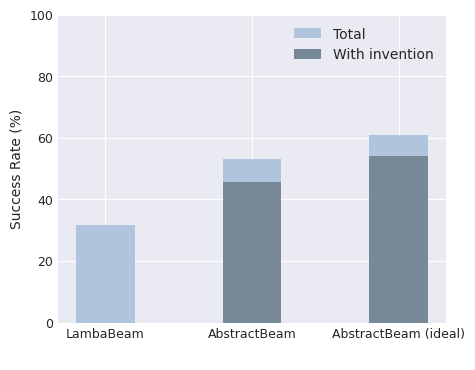

In [17]:
import matplotlib.pyplot as plt
import numpy as np
eval_path = "/work/ldierkes/repos/new/LambdaBeam/outputs/baseline_3/eval/"
all_successes = []
for i in range(1, 6):
    with open(eval_path + f"results_{i}.json") as f:
        results = json.load(f)["results"]

    successes = 0
    successes_with_invention = 0
    
    # Count successes and invention occurrences
    for result in results:
        used_inv = False
        if result["success"]:
            successes += 1

    all_successes.append(successes/len(results) * 100) 

succes_rate_with_inv_per_approach.insert(0, 0)
success_rate_per_approach.insert(0, np.mean(all_successes))
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(5, 4))  # Adjust figure size as needed
colors = ["#778899", "#B0C4DE", "#84a97e"]

# Define the data
approaches = ["LambaBeam", 'AbstractBeam', 'AbstractBeam (ideal)']

bar_width = 0.4
index = np.arange(len(approaches))

plt.bar(approaches, success_rate_per_approach, color=colors[1], width=bar_width, label='Total')
plt.bar(approaches, succes_rate_with_inv_per_approach, color=colors[0], width=bar_width, label='With invention')

plt.legend()
plt.ylim(0, 100)
plt.xlabel(" ")
plt.ylabel('Success Rate (%)')
plt.show()


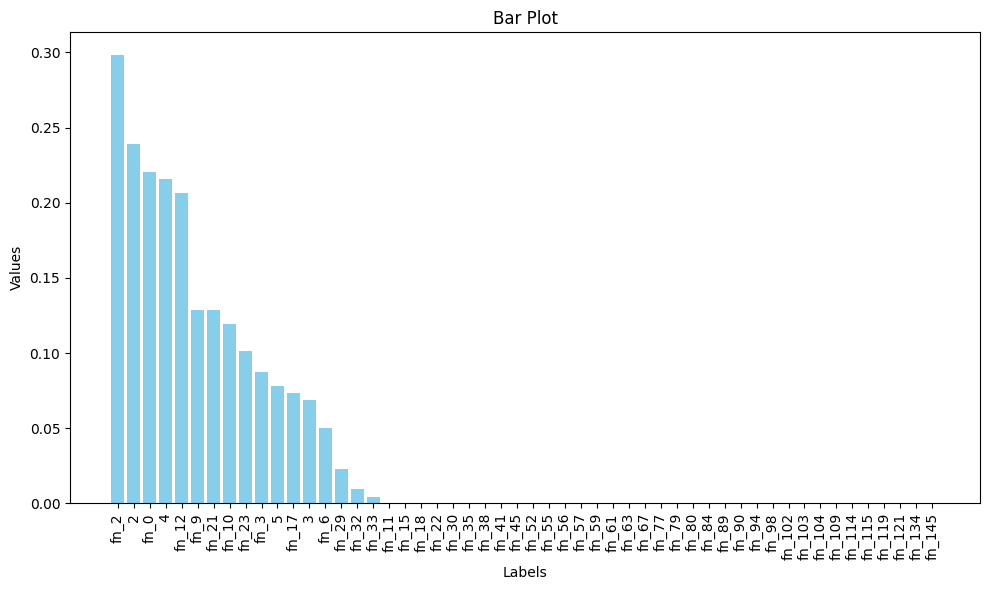

In [4]:
# open ckpt file 
import torch
import json
with open("/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/model-best-valid.ckpt", "rb") as f:
    ckpt = torch.load(f)

invention_names = [inv.name for inv in ckpt["inventions"]]


invention_counter = {name: 0 for name in invention_names}
for i in range(2, 6):
    invention_counter[f"{i}"] = 0

approach = "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/all_inventions/eval/"
max_successes = 0
for i in range(1, 6):  # Loop over the 5 runs
    with open(approach + f"results_{i}.json") as f:
        results = json.load(f)["results"]
    successes = 0
    for result in results:
        if result["success"]:
            successes += 1
            for invention in invention_names:
                if invention in result["solution"]:
                    invention_counter[invention] += 1
            for i in range(2, 6):
                if f"({i}" in result["solution"] or f",{i}" in result["solution"] or f" {i})" in result["solution"]:
                    invention_counter[f"{i}"] += 1
    if successes > max_successes:
        max_successes = successes

invention_counter = {k: round((v / 5) / max_successes * 100, 2) for k, v in invention_counter.items()}

inventions_usage = sorted(invention_counter.items(), key=lambda x: x[1], reverse=True)
top_10_inventions = inventions_usage

from matplotlib import pyplot as plt

# Separate labels and values
labels, values = zip(*top_10_inventions)


# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(labels, [value / max_successes for value in values], color='skyblue')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Values')
plt.title('Bar Plot')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show plot
plt.tight_layout()
plt.show()

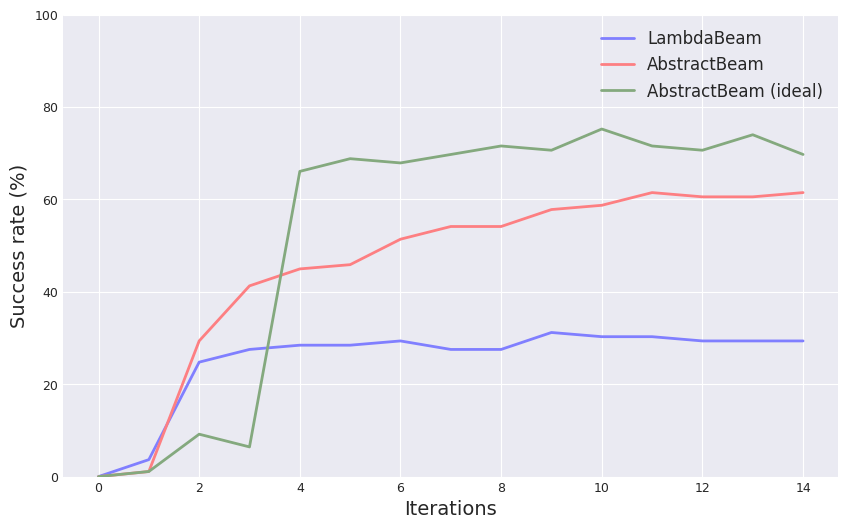

In [18]:
import matplotlib.pyplot as plt

# Data
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
LambdaBeam = [0, 0.0367, 0.2477, 0.2752, 0.2844, 0.2844, 0.2936, 0.2752, 0.2752, 0.3119, 0.3028, 0.3028, 0.2936, 0.2936, 0.2936]
AbstractBeam = [0, 0.0109, 0.2936, 0.4128, 0.4495, 0.4587, 0.5138, 0.5413, 0.5413, 0.578, 0.5872, 0.6147, 0.6055, 0.6055, 0.6147]
AbstractBeam_ideal = [0, 0.01101, 0.09174, 0.06422, 0.6606, 0.6881, 0.6789, 0.6972, 0.7156, 0.7064, 0.7523, 0.7156, 0.7064, 0.7399, 0.6972]

plt.style.use('seaborn-v0_8-darkgrid')

# Plot
plt.figure(figsize=(10, 6))

# LambdaBeam
plt.plot(x, [val * 100 for val in LambdaBeam], label='LambdaBeam', color="#807fff", linewidth=2)

# AbstractBeam
plt.plot(x, [val * 100 for val in AbstractBeam], label='AbstractBeam', color="#fd7f82", linewidth=2)

# AbstractBeam (ideal)
plt.plot(x, [val * 100 for val in AbstractBeam_ideal], label='AbstractBeam (ideal)', color="#84a97e", linewidth=2)

# Adding labels and title
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Success rate (%)', fontsize=14)
plt.legend(fontsize=12)

plt.ylim(0, 100)
# Show plot
plt.grid(True)
plt.show()


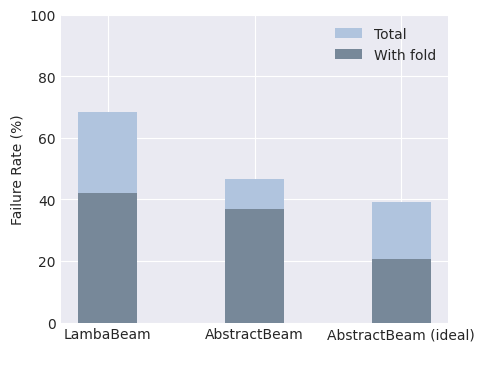

In [6]:
import pickle
import json
import re
import json
import matplotlib.pyplot as plt
import numpy as np

with open("/work/ldierkes/repos/new/LambdaBeam/crossbeam/data/dreamcoder_test_tasks.pkl", "rb") as f:
    test_tasks = pickle.load(f)
test_names = [task.name for task in test_tasks]

with open("/work/ldierkes/repos/new/LambdaBeam/consolidation/data/task_to_length.json", "r") as f:
    data = json.load(f)

tasks_required_fold = []
for name, task in data.items():
    if name in test_names:
        if "fold" in task[0]:
            tasks_required_fold.append(name)

approaches = [
    "/work/ldierkes/repos/new/LambdaBeam/outputs/baseline_3/eval/",
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/eval/",
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/all_inventions/eval/"
]

labels = ["LambdaBeam", "AbstractBeam", "AbstractBeam (ideal)"]

fails_average_data = []
fails_with_fold_average_data = []

for label, approach in zip(labels, approaches):
    all_fails_with_fold_avg = 0
    fails_average = 0
    name_pattern = re.compile(r"name='(.*?)'")

    for i in range(1, 6):
        with open(approach + f"results_{i}.json") as f:
            results = json.load(f)["results"]

        for result in results:
            used_inv = False
            if not result["success"]:
                name = name_pattern.search(result["task"]).group(1)
                if name in tasks_required_fold:
                    all_fails_with_fold_avg += 1
                    fails_average += 1
                else:
                    fails_average += 1


    fails_average = fails_average / (5 * len(results)) * 100
    all_fails_with_fold_avg = all_fails_with_fold_avg / (5 * len(results)) * 100
    fails_average_data.append(fails_average)
    fails_with_fold_average_data.append(all_fails_with_fold_avg)

# Plotting
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(5, 4))  # Adjust figure size as needed
colors = ["#778899", "#B0C4DE", "#84a97e"]

# Define the data
approaches = ["LambaBeam", 'AbstractBeam', 'AbstractBeam (ideal)']

bar_width = 0.4
index = np.arange(len(approaches))

plt.bar(approaches, fails_average_data, color=colors[1], width=bar_width, label='Total')
plt.bar(approaches, fails_with_fold_average_data, color=colors[0], width=bar_width, label='With fold')

plt.legend()
plt.ylim(0, 100)
plt.xlabel(" ")
plt.ylabel('Failure Rate (%)')
plt.show()


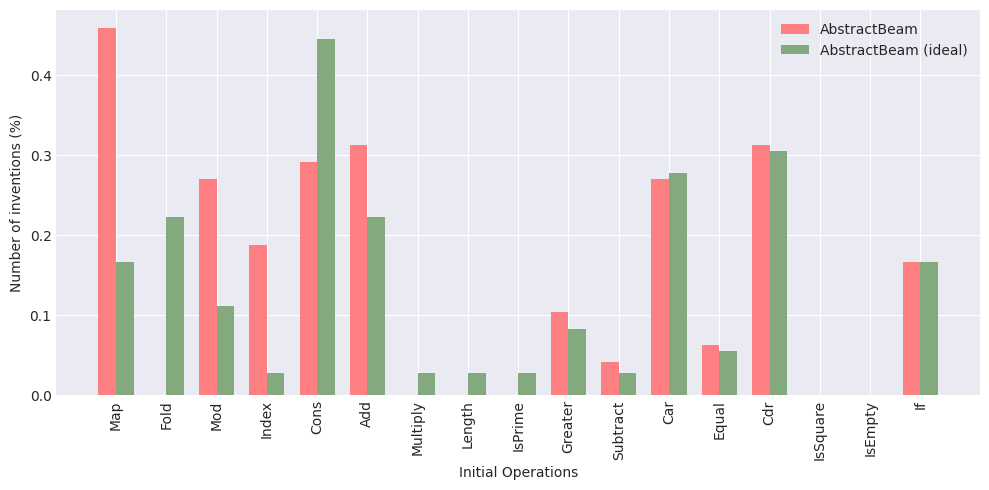

In [50]:
from crossbeam.abstraction.utils import *
import re
import torch
import matplotlib.pyplot as plt

approaches = [
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top_and_avg_2/",
    "/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/all_inventions/"
]

lengths = []
op_counters = []

# Loop through approaches
for approach in approaches: 
    with open(approach + "model-best-valid.ckpt", "rb") as f:
        ckpt = torch.load(f)
    
    # Calculate lengths
    lengths.append(len(ckpt["inventions"]))
    
    # Extract name_to_program_map
    name_to_program_map = {ckpt["inventions"][i].name: ckpt["inventions"][i].program for i in range(len(ckpt["inventions"]) - 1)}
    base_function_dict = get_function_dict()
    
    # Initialize op_counter
    op_counter = {op: 0 for op in base_function_dict.keys()}
    
    # Loop through inventions
    for inv in ckpt["inventions"]:
        tokens = [token for token in re.findall(r'-?\b\w+\b|[():\[\]]', inv.program) if token.strip()]
        for token in tokens:
            if "fn" in token:
                sub_program = name_to_program_map[token]
                tokens.extend(re.findall(r'-?\b\w+\b|[():\[\]]', sub_program))
        
        # Count occurrences of ops
        for op in base_function_dict.keys():
            if op in tokens:
                op_counter[op] += 1
    
    # Append op_counter to op_counters
    op_counters.append(op_counter)

# Extract keys and values for both approaches
keys = list(op_counters[0].keys())
values1 = op_counters[0].values()
values1 = [val / lengths[0] for val in values1]
values2 = op_counters[1].values()
values2 = [val / lengths[1] for val in values2]

# Calculate absolute differences between the values of the two approaches for each key
differences = [abs(val1 - val2) for val1, val2 in zip(values1, values2)]

# Sort keys based on absolute differences
sorted_keys = [key for _, key in sorted(zip(differences, keys), reverse=True)]

# Plotting
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(keys))

# Reorder values for plotting based on sorted keys
values1_sorted = [values1[keys.index(key)] for key in sorted_keys]
values2_sorted = [values2[keys.index(key)] for key in sorted_keys]

plt.bar(index, values1_sorted, bar_width, label='AbstractBeam', color="#fd7f82")
plt.bar([i + bar_width for i in index], values2_sorted, bar_width, label='AbstractBeam (ideal)', color="#84a97e")

plt.ylabel('Number of inventions (%)')
plt.xlabel('Initial Operations')
plt.xticks([i + bar_width / 2 for i in index], sorted_keys, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
index

[7, 0, 11, 9, 10, 16, 15, 5, 3, 4, 1, 2, 6, 8, 12, 13, 14]

In [36]:
op_counters[1]

{'Add': 8,
 'Subtract': 1,
 'Multiply': 1,
 'Greater': 3,
 'Equal': 2,
 'If': 6,
 'Fold': 8,
 'Map': 6,
 'IsEmpty': 0,
 'Cons': 16,
 'Car': 10,
 'Cdr': 11,
 'IsSquare': 0,
 'IsPrime': 1,
 'Length': 1,
 'Index': 1,
 'Mod': 4}

In [35]:
for inv in ckpt["inventions"]:
    print(inv.name, inv.program)

fn_0 Cdr(Cdr(x1))
fn_2 x1(Cdr(Cdr(x2)))
fn_3 Cons(Car(x1), x2)
fn_6 fn_0(Cdr(x1))
fn_9 Map((lambda v1: Mod(v1, x1)), x2)
fn_10 Cons(Car(x1(x2)), x3)
fn_11 Map((lambda v1: x1(1, v1)), x2)
fn_12 Cons(Car(x2), x3)
fn_15 Index(Add(1, 1), x1)
fn_17 x1(fn_0(Cdr(x2)))
fn_18 Add(1, x1)
fn_21 fn_9(Add(1, x2), fn_11(x1, x3))
fn_22 Cons(fn_15(x1), x2)
fn_23 x1(x3, x2(Cdr(x3), x1(fn_0(x3), [])))
fn_29 Map((lambda v1: x2(Cdr(x1))), x1)
fn_30 Subtract(1, x1)
fn_32 Cons(Car(Cdr(x1)), x2)
fn_33 fn_9(x2, Map((lambda v1: x1(v1)), x3))
fn_35 fn_3(x2, Cons(Car(Cdr(x2)), x3))
fn_38 fn_9(x2, fn_11(x1, x3))
fn_41 Cons(Car(x1), [])
fn_45 Add(2, x1)
fn_52 If(x1, 1, 0)
fn_55 fn_9(3, fn_11((lambda u1, v1: (())), x1))
fn_56 fn_32(x2, fn_22(x2, x1))
fn_57 Map((lambda v1: 0), x1)
fn_59 fn_3(x3, fn_56(x2(x1(x3)), x3))
fn_61 Cons(fn_15(fn_0(x1)), fn_41(fn_6(fn_0(x1))))
fn_63 If(Greater(fn_9(2, x1), x2(x1)), x4, x3)
fn_67 fn_11((lambda u1, v1: (fn_52(Greater(v1, x1)))), x2)
fn_77 fn_67(x1, x2)
fn_79 fn_9(3, x1)
fn_80 

In [21]:
with open("/work/ldierkes/repos/new/LambdaBeam/crossbeam/data/dreamcoder_test_tasks.pkl", "rb") as f:
    test_tasks = pickle.load(f)
test_names = [task.name for task in test_tasks]
first_tree_inpts = [task.inputs_dict["x1"][:1] for task in test_tasks]
first_tree_outs = [task.outputs[:1] for task in test_tasks]

In [ ]:
for i, name in enumerate(test_names):
    print(name)
    print(first_tree_inpts[i])
    print(first_tree_outs[i])
    print("------------")

In [14]:
import pickle
with open("/work/ldierkes/repos/new/LambdaBeam/crossbeam/data/dreamcoder_train_tasks.pkl", "rb") as f:
    train_tasks = pickle.load(f)
test_names_train = [task.name for task in train_tasks]
first_tree_inpts_train = [task.inputs_dict["x1"][:3] for task in train_tasks]
first_tree_outs_train = [task.outputs[:1] for task in train_tasks]

In [25]:
for i, name in enumerate(test_names):
    print(test_names_train[i])
    print(f"{name}")
    


add-k with k=1
add-k with k=5
add-k with k=3
append-index-k with k=1
add-k with k=4
append-index-k with k=5
append-index-k with k=2
append-k with k=1
append-index-k with k=3
append-k with k=2
append-index-k with k=4
bool-identify-geq-k with k=5
append-k with k=0
bool-identify-is-mod-k with k=2
append-k with k=3
bool-identify-is-mod-k with k=5
append-k with k=4
bool-identify-k with k=5
append-k with k=5
caesar-cipher-k-modulo-n with k=1 and n=4
bool-identify-geq-k with k=0
caesar-cipher-k-modulo-n with k=2 and n=3
bool-identify-geq-k with k=1
caesar-cipher-k-modulo-n with k=2 and n=4
bool-identify-geq-k with k=4
caesar-cipher-k-modulo-n with k=2 and n=5
bool-identify-is-mod-k with k=3
caesar-cipher-k-modulo-n with k=3 and n=5
bool-identify-is-mod-k with k=4
caesar-cipher-k-modulo-n with k=4 and n=5
bool-identify-k with k=3
count-k with k=1
bool-identify-k with k=4
count-k with k=2
caesar-cipher-k-modulo-n with k=1 and n=2
count-k with k=4
caesar-cipher-k-modulo-n with k=1 and n=3
dup
ca